# Clustering

En aquest apartat busquem la creació de noves variables referents als autors, amb l'objectiu de definir un criteri de classificació d'aquests.
Treballem amb una submostra aleatoria de 100.000 edicions per agilitzar el procés de càlcul.

In [10]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

 
df=pd.read_csv("WesC_clean.csv",sep=",",header=0,index_col=0)
df = df.drop('DataN.1', 1)
#df=df.sample(100000)
df=df.sample(10000)
df.Autor=df.Autor.astype(int)
df.Autor= "Aut. " + df.Autor.astype(str)

En primer lloc creem una llista de tots els articles presents a la mostra segons el nombre de modificacions que se li han fet.

In [11]:
llistaarticles=pd.DataFrame()
llistaarticles["Nom"]=""
llistaarticles["Modificacions"]=0
i=0
for article in tqdm.tqdm(np.unique(df.Article.values)):
    llistaarticles.loc[i,"Nom"]=article
    llistaarticles.loc[i,"Modificacions"]=len(df[df.Article.values==article])
    i=i+1

100%|█████████████████████████████████████████████████████████████████████████████| 9552/9552 [00:23<00:00, 408.76it/s]


A continuació creem un dataframe on es guardarà la informació corresponent a cadascun dels autors, amb les noves variables, que són:

-El percentatge màxim de contribució total d'un article que correspon a l'autor

-El percentatge mitjà de contribució d'aquest autor a tots els articles on ha contribuït

-El nombre de contribucions

-El nombre d'articles on ha contribuït

-La relació entre contribucions i articles contribuïts

-El període d'activitat de l'autor

In [12]:
llistaautors=pd.DataFrame()
llistaautors["Nom"]=""
llistaautors["Contribuciomaxima"]=0
llistaautors["Contribuciomitjana"]=0
llistaautors["Numerocontribucions"]=0
llistaautors["Articlescontribuits"]=0
llistaautors["Periodeactivitat"]=0
llistaautors["Contribucions/article"]=0

In [13]:
i=0
for autor in tqdm.tqdm(np.unique(df.Autor.values)):
    dfaux=df[df.Autor.values==autor]
    llistaautors.loc[i,"Nom"]=autor
    maxim=0
    mitjana=0
    for article in np.unique(dfaux.Article.values):
        percentatge=len(dfaux[dfaux.Article.values==article])/llistaarticles.Modificacions.values[llistaarticles.Nom.values==article]    
        mitjana=mitjana+percentatge
        if(percentatge>maxim):
            maxim=percentatge
    llistaautors.loc[i,"Contribuciomaxima"]=maxim*100      
    llistaautors.loc[i,"Contribuciomitjana"]=mitjana/len(np.unique(dfaux.Article.values))*100
    llistaautors.loc[i,"Articlescontribuits"]=len(np.unique(dfaux.Article.values))
    llistaautors.loc[i,"Numerocontribucions"]=len(dfaux)
    llistaautors.loc[i,"Periodeactivitat"]=max(dfaux.Data.values)-min(dfaux.Data.values)    
    llistaautors.loc[i,"Contribucions/article"]=llistaautors.loc[i,"Numerocontribucions"]/llistaautors.loc[i,"Articlescontribuits"]
    i=i+1

100%|█████████████████████████████████████████████████████████████████████████████| 2774/2774 [00:13<00:00, 198.33it/s]


Un cop disposem de la llista d'autors, ens cal normalitzar les variables per a tal de classificar-les correctament sense que l'escala de cadascuna d'elles sigui influent.

In [14]:
X=llistaautors.iloc[:,1:6]
X=X.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))

Un cop fet això, apliquem l'algoritme K-means per a trobar una bona agrupació dels autors en 3 grups (escollit arbitràriament), i mostrem gràficament les parelles de variables més rellevants.

In [15]:
kmeans = KMeans(n_clusters=3, random_state=0,init="k-means++").fit(X)
kmeans.cluster_centers_
colormap = np.array(['red','black','blue'])

L'encreuament de variables que permet veure més clarament aquelles que el K-means ha donat més importància és el percentatge de contribució mitjana d'un autor i el seu període d'activitat, i com pot comprovar-se també, la visualització en dues dimensions d'altres variables, podem mostrar aquelles on es diferencien els grups, però hi ha unes fronteres menys definides.

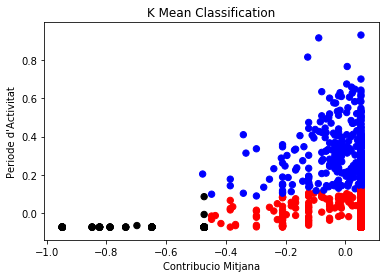

In [16]:
plt.scatter(X.iloc[:,1], X.iloc[:,4], c=colormap[kmeans.labels_], s=40)
plt.title('K Mean Classification')
plt.xlabel("Contribucio Mitjana")
plt.ylabel("Periode d'Activitat")
plt.show()

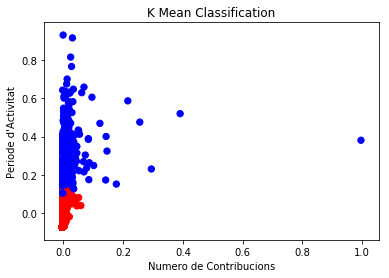

In [17]:
plt.scatter(X.iloc[:,2], X.iloc[:,4], c=colormap[kmeans.labels_], s=40)
plt.title('K Mean Classification')
plt.xlabel("Numero de Contribucions")
plt.ylabel("Periode d'Activitat")
plt.show()

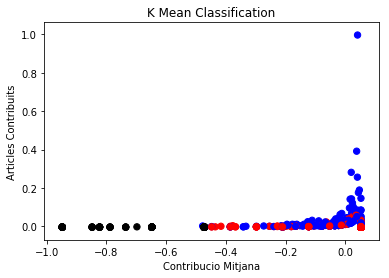

In [18]:
plt.scatter(X.iloc[:,1], X.iloc[:,3], c=colormap[kmeans.labels_], s=40) 
plt.title('K Mean Classification')
plt.xlabel("Contribucio Mitjana")
plt.ylabel("Articles Contribuits")
plt.show()

L'encreuament d'altres variables dóna uns resultats gens informatius a nivell visual.

# Bootstrap i Inferència

En aquest apartat es busca avaluar si treballant amb una sub-mostra, podem inferir algun dels paràmetres de la xarxa global. Per a tal finalitat es realitzarà un bootstrap per casos, i per altra banda un mostreig clàssic, per a veure si el paràmetre poblacional s'inclou dins de les submostres.

In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from bokeh.charts import Histogram
import tqdm as tqdm
 
df=pd.read_csv("WesC_clean.csv",sep=",",header=0,index_col=0,nrows=1000000)
df = df.drop('DataN.1', 1)
df = df.drop('Data', 1) #Eliminar el temps

df.Autor=df.Autor.astype(int)
df.Autor= "Aut. " + df.Autor.astype(str)
df=df.sample(5000)
G=nx.from_pandas_dataframe(df,source="Autor",target="Article")

Creem una xarxa de 5000 edicions, d'entre el primer milió d'edicions de la base de dades completa. No és possible avaluar amb un temps raonable depèn de quin aspecte d'una xarxa de més de 5000 edicions, com pot ser el betweenness centrality, és a dir, el nombre de camins curts que passen per cada node, ja que el temps de càlcul creix enormement al augmentar la mostra. S'han escollit com a paràmetres a estimar el quocient entre Nodes i Vèrtexs, la mitjana de betweenness centrality de la xarxa i el percentatge màxim de camins curts que passen per un node concret. A continuació avaluem els paràmetres de la xarxa que considerem global:

In [ ]:
valorpoblacional=float(G.order())/G.size()
betweenness=nx.betweenness_centrality(G)
valorpoblacional2=np.mean(betweenness.values())
valorpoblacional3=np.max(betweenness.values())

 I creem els objectes per a guardar els resultats del bootstrap i dels mostrejos:

In [ ]:
size=500 #Mida de les mostres
rep=1000 #Nombre de repeticions
dfboot=df.sample(size)
bootlist=list()
bootlist2=list()
bootlist3=list()
samplelist=list()
samplelist2=list()
samplelist3=list()

A continuació el loop on generem les mostres bootstrap i els mostrejos clàssics, i anem guardant els resultats.

In [ ]:
for i in tqdm.tqdm(xrange(0,rep)):
    dfbootaux=dfboot.sample(size,replace=True)
    Gboot=nx.from_pandas_dataframe(dfbootaux,source="Autor",target="Article")
    bootlist.append(float(Gboot.order())/Gboot.size())#Average Degree
    betboot=nx.betweenness_centrality(Gboot).values()
    bootlist2.append(np.mean(betboot))#Average Degree
    bootlist3.append(np.max(betboot))
    dfsample=df.sample(size)
    Gsample=nx.from_pandas_dataframe(dfsample,source="Autor",target="Article")
    samplelist.append(float(Gsample.order())/Gsample.size())#Average Degree
    betsample=nx.betweenness_centrality(Gsample).values()
    samplelist2.append(np.mean(betsample))#Average Degree
    samplelist3.append(np.max(betsample))

Els resultats referents al quocient Nodes/Vèrtexs:

In [ ]:
print valorpoblacional
print np.percentile(bootlist,[5,95])
print np.percentile(samplelist,[5,95])

Els resultats referents a la mitjana del Betweenness Centrality

In [ ]:
print valorpoblacional2
print np.percentile(bootlist2,[5,95])
print np.percentile(samplelist2,[5,95])

I finalment els resultats corresponents al percentatge màxim de camins curts que passen per un sol node:

In [ ]:
print valorpoblacional3
print np.percentile(bootlist3,[5,95])
print np.percentile(samplelist3,[5,95])

En cap dels 3 paràmetres observats, el valor poblacional cau dins dels intervals de credibilitat bootstrap basats en el percentil, ni apareix en els percentils d'un mostreig clàssic (per a fer-ne una comparació). El qual ens porta a la conclusió que l'estructura en xarxa no es pot estudiar amb una mostra del total, ja que es perden els valors reals de la xarxa. Així doncs, una xarxa s'ha d'entendre com un total, i estudiar-ne sub-mostres no permet estimar els paràmetres globals.

Per a futurs treballs sobre el tema, s'hauria d'estudiar si els nodes més importants de la xarxa global, acaben sent els mateixos que a les submostren, i amb quina freqüència.